In [70]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [71]:
import sys
sys.path.insert(0, '..')
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (14, 9)
plt.rcParams['font.size'] = 16
import numpy as np
import pandas as pd
import seaborn as sns

import covid19

PALETTE = sns.color_palette()

## data

In [72]:
data_italy_path = 'dpc-covid19-ita-andamento-nazionale.csv'
data_italy_path = covid19.data.download('andamento-nazionale')

In [73]:
data_italy = pd.read_csv(data_italy_path, parse_dates=['data'], index_col=['data'])
data_italy.index = data_italy.index.normalize()

for column in ['ricoverati_con_sintomi', 'terapia_intensiva', 'deceduti']:
    data_italy['variazione_' + column] = data_italy[column].diff(1)

data_italy.tail()

,stato,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_positivi,variazione_totale_positivi,nuovi_positivi,dimessi_guariti,deceduti,totale_casi,tamponi,note_it,note_en,variazione_ricoverati_con_sintomi,variazione_terapia_intensiva,variazione_deceduti
data,,,,,,,,,,,,,,,,,
2020-04-10,ITA,28242,3497,31739,66534,98273,1396,3951,30455,18849,147577,906864,pd-IT-0011,pd-EN-0011,-157.0,-108.0,570.0
2020-04-11,ITA,28144,3381,31525,68744,100269,1996,4694,32534,19468,152271,963473,NaN,NaN,-98.0,-116.0,619.0
2020-04-12,ITA,27847,3343,31190,71063,102253,1984,4092,34211,19899,156363,1010193,dc-IT-0003,dc-EN-0003,-297.0,-38.0,431.0
2020-04-13,ITA,28023,3260,31283,72333,103616,1363,3153,35435,20465,159516,1046910,NaN,NaN,176.0,-83.0,566.0
2020-04-14,ITA,28011,3186,31197,73094,104291,675,2972,37130,21067,162488,1073689,NaN,NaN,-12.0,-74.0,602.0


## situation report

In [74]:
DAY = np.timedelta64(24 * 60 * 60, 's')
PALETTE_ONE = list(sns.color_palette())

START_FIT = '2020-02-23'
STOP_FIT = '2020-04-01'

SHOWUNTIL = np.datetime64(data_italy.index.max(), 's') + 3 * DAY

EXTRAPOLATE = (np.datetime64('2020-02-23'), SHOWUNTIL)
XLIM = EXTRAPOLATE

FIT_PARAMS = {
    'ricoverati_con_sintomi': [None, '2020-03-07', '2020-03-08', '2020-03-20'],
    'terapia_intensiva': 0,
    'variazione_deceduti': 0,
}
RATIO = {
    'ricoverati_con_sintomi': 35,
    'terapia_intensiva': 6.5,
    'variazione_deceduti': 1,
}
LABEL = {
    'ricoverati_con_sintomi': 'Pazienti attualmente ricoverati in reparto',
    'terapia_intensiva': 'Pazienti attualmente in terapia intensiva',
    'variazione_deceduti': 'Decessi giornalieri',
}

In [75]:
fits = {}
for kind, breaks in FIT_PARAMS.items():
    if isinstance(breaks, int):
        breaks = [np.datetime64(b) + breaks * DAY if b is not None else b for b in FIT_PARAMS['ricoverati_con_sintomi']]
    fits[kind] = covid19.fit.fit_exponential_segments(data_italy[kind], breaks=breaks)

#fits['dimessi_guariti'] = covid19.fit.ExponentialFit.from_frame(data_italy['dimessi_guariti'], start='2020-03-08', stop=STOP_FIT)
#fits['totale_casi_1'] = covid19.fit.ExponentialFit.from_frame(data_italy['totale_casi'], start=START_FIT, stop='2020-02-29')
#fits['totale_casi'] = covid19.fit.ExponentialFit.from_frame(data_italy['totale_casi'], start='2020-03-01', stop='2020-03-09')

#fits['ricoverati_con_sintomi_1'] = covid19.fit.ExponentialFit.from_frame(data_italy['ricoverati_con_sintomi'], start=START_FIT, stop='2020-03-06')
#fits['ricoverati_con_sintomi_2'] = covid19.fit.ExponentialFit.from_frame(data_italy['ricoverati_con_sintomi'], start='2020-03-08', stop='2020-03-19')
#fits['terapia_intensiva_1'] = covid19.fit.ExponentialFit.from_frame(data_italy['terapia_intensiva'], start=START_FIT, stop='2020-03-06')
#fits['terapia_intensiva_2'] = covid19.fit.ExponentialFit.from_frame(data_italy['terapia_intensiva'], start='2020-03-07', stop='2020-03-13')
#fits['terapia_intensiva_3'] = covid19.fit.ExponentialFit.from_frame(data_italy['terapia_intensiva'], start='2020-03-14', stop='2020-03-18')
#fits['terapia_intensiva_4'] = covid19.fit.ExponentialFit.from_frame(data_italy['terapia_intensiva'], start='2020-03-19', stop='2020-03-24')
#fits['deceduti_1'] = covid19.fit.ExponentialFit.from_frame(data_italy['variazione_deceduti'], start=START_FIT, stop='2020-03-11')
#fits['deceduti_2'] = covid19.fit.ExponentialFit.from_frame(data_italy['variazione_deceduti'], start='2020-03-12', stop='2020-03-21')

#fits['ricoverati_con_sintomi'] = covid19.fit.ExponentialFit.from_frame(data_italy['ricoverati_con_sintomi'], start='2020-03-27', stop=STOP_FIT)
#fits['terapia_intensiva'] = covid19.fit.ExponentialFit.from_frame(data_italy['terapia_intensiva'], start='2020-03-25', stop=STOP_FIT)
#fits['deceduti'] = covid19.fit.ExponentialFit.from_frame(data_italy['variazione_deceduti'], start='2020-03-27', stop=STOP_FIT)


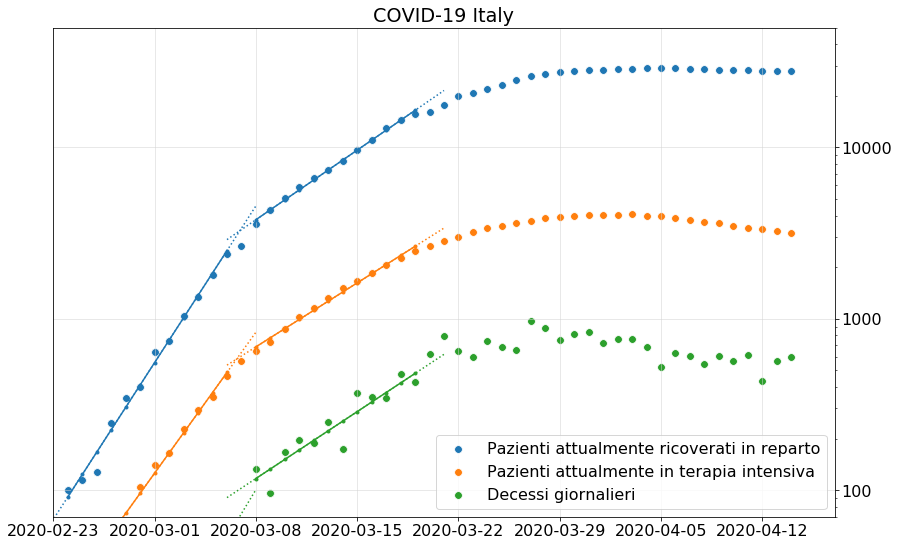

In [76]:
_, ax = plt.subplots(1, subplot_kw={'xlim': XLIM})
ax.set(yscale='log', ylim=(70, 50000)) 
ax.set_title(f'COVID-19 Italy')
ax.yaxis.tick_right()
ax.yaxis.grid(color='lightgrey', linewidth=0.5)
ax.xaxis.grid(color='lightgrey', linewidth=0.5)

for (kind, fits_kind), color in zip(fits.items(), PALETTE_ONE):
    label = LABEL[kind]
    covid19.plot.plot_data(ax, data_italy[kind], label=label, color=color)
    for fit in fits_kind:
        covid19.plot.plot(ax, data_italy[kind], fit, color=color, date_interval=7, add_diff=False)

#ax[1].set(ylim=(0, None)) 

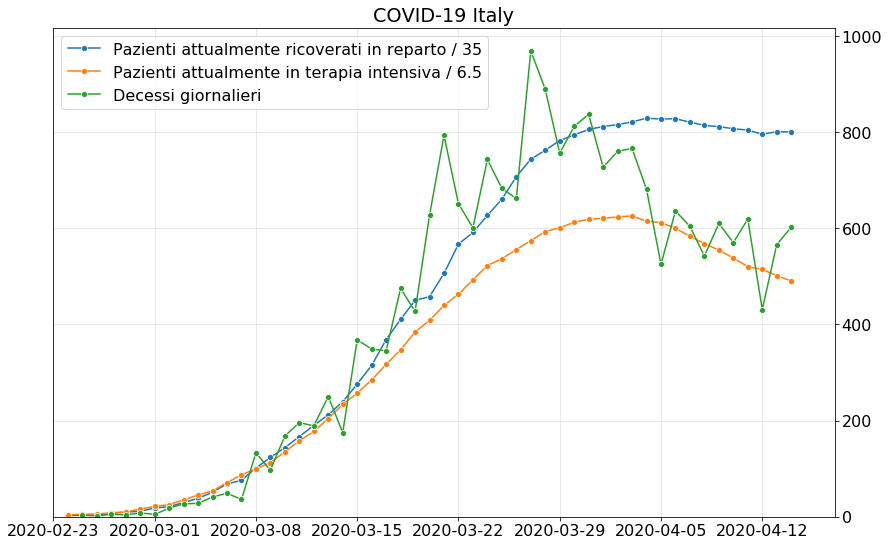

In [77]:
_, ax = plt.subplots(1, subplot_kw={'xlim': XLIM})
ax.set_title(f'COVID-19 Italy')
ax.yaxis.tick_right()
ax.yaxis.grid(color='lightgrey', linewidth=0.5)
ax.xaxis.grid(color='lightgrey', linewidth=0.5)

for (kind, fits_kind), color in zip(fits.items(), PALETTE_ONE):
    label = LABEL[kind] + ('' if RATIO[kind] == 1 else f' / {RATIO[kind]}')
    covid19.plot.plot_data(ax, data_italy[kind] / RATIO[kind], label=label, color=color, kind='line', marker='o')
    #for fit in fits_kind:
    #    covid19.plot.plot(ax, data_italy[kind] / RATIO[kind], fit.scale(1 / RATIO[kind]), color=color, date_interval=7, add_diff=False, kind='line', marker='o')

_ = ax.set(ylim=(0, None))

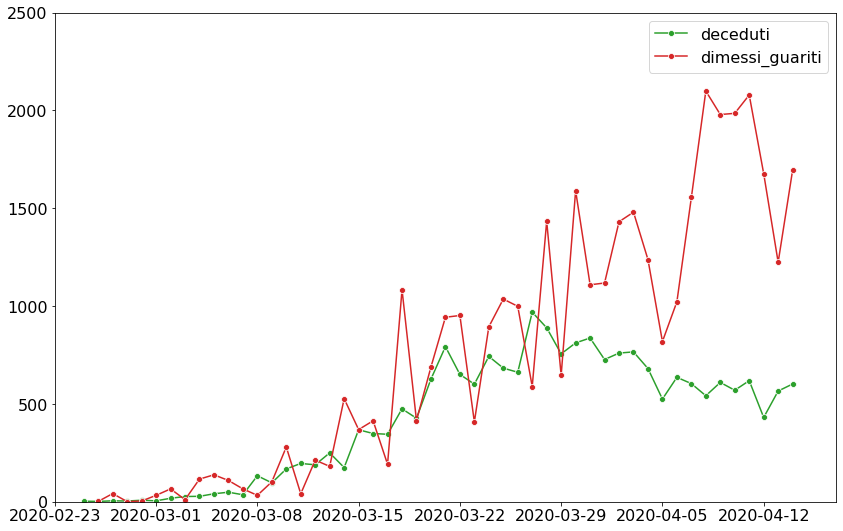

In [78]:
_, ax = plt.subplots(subplot_kw={'ylim': (0, 2500), 'xlim': EXTRAPOLATE})
kind = 'dimessi_guariti'
covid19.plot.plot_data(ax, data_italy['variazione_deceduti'], label='deceduti',  color=color, kind='line', marker='o')
covid19.plot.plot_data(ax, data_italy['dimessi_guariti'].diff(1), label='dimessi_guariti', kind='line', marker='o')
# covid19.plot.plot(ax, data_italy[kind], fits['dimessi_guariti'], label=kind, color=color)


In [79]:
data_italy.tail(10)

,stato,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_positivi,variazione_totale_positivi,nuovi_positivi,dimessi_guariti,deceduti,totale_casi,tamponi,note_it,note_en,variazione_ricoverati_con_sintomi,variazione_terapia_intensiva,variazione_deceduti
data,,,,,,,,,,,,,,,,,
2020-04-05,ITA,28949,3977,32926,58320,91246,2972,4316,21815,15887,128948,691461,NaN,NaN,-61.0,-17.0,525.0
2020-04-06,ITA,28976,3898,32874,60313,93187,1941,3599,22837,16523,132547,721732,NaN,NaN,27.0,-79.0,636.0
2020-04-07,ITA,28718,3792,32510,61557,94067,880,3039,24392,17127,135586,755445,NaN,NaN,-258.0,-106.0,604.0
2020-04-08,ITA,28485,3693,32178,63084,95262,1195,3836,26491,17669,139422,807125,NaN,NaN,-233.0,-99.0,542.0
2020-04-09,ITA,28399,3605,32004,64873,96877,1615,4204,28470,18279,143626,853369,NaN,NaN,-86.0,-88.0,610.0
2020-04-10,ITA,28242,3497,31739,66534,98273,1396,3951,30455,18849,147577,906864,pd-IT-0011,pd-EN-0011,-157.0,-108.0,570.0
2020-04-11,ITA,28144,3381,31525,68744,100269,1996,4694,32534,19468,152271,963473,NaN,NaN,-98.0,-116.0,619.0
2020-04-12,ITA,27847,3343,31190,71063,102253,1984,4092,34211,19899,156363,1010193,dc-IT-0003,dc-EN-0003,-297.0,-38.0,431.0
2020-04-13,ITA,28023,3260,31283,72333,103616,1363,3153,35435,20465,159516,1046910,NaN,NaN,176.0,-83.0,566.0
